# Notes
- This is useless

In [1]:
import numpy as np
import pandas as pd

import sqlite3
from sqlite3 import Error

import matplotlib.pyplot as plt
import seaborn as sns

import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

from joblib import dump, load

In [2]:
db_path = "../../dbs/delays_new.db"

In [3]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        connection.text_factory = str
    except Error as e:
        print("Error occurred: " + str(e))
    return connection


def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        if query == "":
            return "Query Blank"
        else:
            df = pd.read_sql_query(query, connection)
            return df
    except Error as e:
        return "Error occurred: " + str(e)

In [4]:
def preprocess_inputs(df, use_departure_delay):
    
    df = df.copy()
    
    categorical_features = ['IATA_CODE_Reporting_Airline', 'OriginAirportID', 'DestAirportID', 'Month', 'DayofMonth', 'DayOfWeek', 'DepHour']
    
    if (not use_departure_delay):
        df = df.drop('DepDelay', axis=1)
    
    y = (df.ArrDelay>15).astype(int)
    X = df.drop('ArrDelay', axis=1)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

    categorical_train = X_train[categorical_features]
    
    one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
    one_hot_encoder.fit(categorical_train)

    encoded_train = pd.DataFrame(data=one_hot_encoder.transform(categorical_train).toarray(), columns=one_hot_encoder.get_feature_names_out(categorical_features), dtype=int)
    X_train = X_train.drop(categorical_features, axis=1).reset_index(drop=True)
    X_train = X_train.join(encoded_train)
    
    dump(one_hot_encoder, 'one_hot_encoder.joblib') 
    one_hot_encoder = load('one_hot_encoder.joblib') 
    
    
    categorical_test = X_test[categorical_features]
    
    encoded_test = pd.DataFrame(data=one_hot_encoder.transform(categorical_test).toarray(), columns=one_hot_encoder.get_feature_names_out(categorical_features), dtype=int)
    X_test = X_test.drop(categorical_features, axis=1).reset_index(drop=True)
    X_test = X_test.join(encoded_test)
    
    smote = SMOTE()
    X_train, y_train = smote.fit_resample(X_train, y_train)
   
 
    # Scale X with a standard scaler
    standard_scaler = StandardScaler()
    standard_scaler.fit(X_train)
        
    dump(standard_scaler, 'standard_scaler_'+str(use_departure_delay)+'.joblib') 
    standard_scaler = load('standard_scaler_'+str(use_departure_delay)+'.joblib') 
    
    X_train = pd.DataFrame(standard_scaler.transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(standard_scaler.transform(X_test), columns=X_test.columns)
   
    return X_train, X_test, y_train, y_test

In [5]:
def evaluate_model(model, X_test, y_test):
    
    model_acc = model.score(X_test, y_test)
    print("Test Accuracy: {:.2f}%".format(model_acc * 100))
    
    y_true = np.array(y_test)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_true, y_pred)
    clr = classification_report(y_true, y_pred, target_names=["Not Delayed", "Delayed"])
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.yticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

In [6]:
sample_query = \
    """
        select 
         Month,
         DayofMonth,
         DayOfWeek,
         SUBSTR(CRSDepTime, 1, LENGTH(CRSDepTime)-2) as DepHour,
         IATA_CODE_Reporting_Airline,
         OriginAirportID,
         DestAirportID,
         AirTime,
         DepDelay,
         ArrDelay
        from 
          delay
         where Cancelled = 0  
         and AirTime > 0 
        order by RANDOM() LIMIT 1000000
    """

connection = create_connection(db_path)
data =  execute_query(connection, sample_query)

Test Accuracy: 82.65%


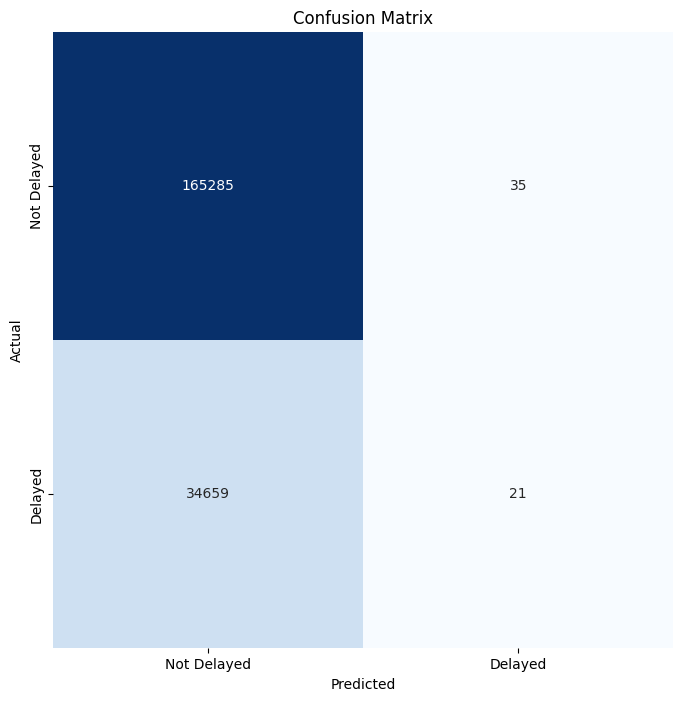

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.83      1.00      0.91    165320
     Delayed       0.38      0.00      0.00     34680

    accuracy                           0.83    200000
   macro avg       0.60      0.50      0.45    200000
weighted avg       0.75      0.83      0.75    200000



In [7]:
X_train, X_test, y_train, y_test = preprocess_inputs(data, use_departure_delay=False)
clf_lr_delay_not_used = LogisticRegression(random_state=42,  solver='lbfgs', max_iter=1000).fit(X_train, y_train)
clf_lr_delay_not_used.fit(X_train, y_train)

dump(clf_lr_delay_not_used, 'clf_lr_delay_not_used.joblib') 
clf_lr_delay_not_used = load('clf_lr_delay_not_used.joblib') 

evaluate_model(clf_lr_delay_not_used, X_test, y_test)

Test Accuracy: 93.61%


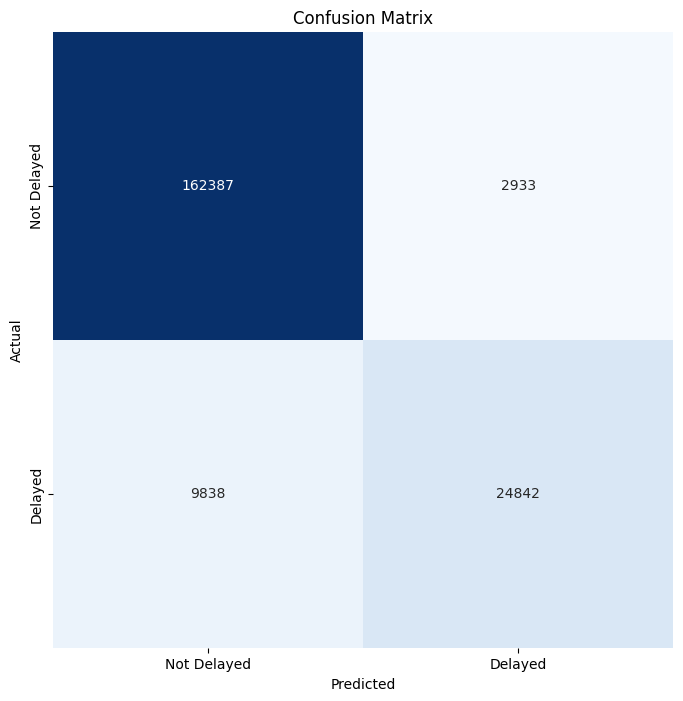

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.94      0.98      0.96    165320
     Delayed       0.89      0.72      0.80     34680

    accuracy                           0.94    200000
   macro avg       0.92      0.85      0.88    200000
weighted avg       0.93      0.94      0.93    200000



In [8]:
X_train, X_test, y_train, y_test = preprocess_inputs(data, use_departure_delay=True)
clf_lr_delay_used = LogisticRegression(random_state=42, solver='lbfgs', max_iter=1000).fit(X_train, y_train)
clf_lr_delay_used.fit(X_train, y_train)

dump(clf_lr_delay_used, 'clf_lr_delay_used.joblib') 
clf_lr_delay_used = load('clf_lr_delay_used.joblib') 

evaluate_model(clf_lr_delay_used, X_test, y_test)